# Bank Marketing Campaign (Classification)
**Dataset:** Bank Marketing Campaign  

## 1) Business Problem Understanding

### Latar belakang
Bank melakukan marketing campaign untuk menawarkan produk deposito.
Namun, menghubungi semua nasabah membutuhkan biaya besar (waktu agent, biaya operasional, dan opportunity cost). Karena itu, bank butuh model untuk **memprioritaskan** siapa yang paling berpotensi menerima penawaran untuk melakukan deposit.

### Problem statement
Bagaimana cara memprediksi nasabah yang berpeluang melakukan deposit, sehingga campaign dapat dilakukan secara lebih tepat sasaran dan efisien?

### Objective
Membangun model klasifikasi machine learning yang dapat:
- Memprediksi kemungkinan nasabah melakukan deposit
- Digunakan untuk membuat prioritas target campaign

### Stakeholder & keputusan bisnis
- **Marketing team / telesales**: menentukan siapa yang dihubungi terlebih dulu
- **Campaign manager**: menentukan threshold / top-N yang akan ditarget

### Objective & Definition of Success

Tujuan utama dari project ini adalah membangun model machine learning yang dapat membantu tim marketing **memprioritaskan nasabah yang paling berpotensi melakukan deposito**, sehingga campaign menjadi lebih efektif dibandingkan pendekatan secara acak.

Keberhasilan model didefinisikan secara **measurable** melalui kriteria berikut:

1. **Recall (kelas “yes”) ≥ 0.90**  
   Target ini ditetapkan untuk memastikan sebagian besar calon depositor berhasil teridentifikasi oleh model, sehingga peluang kehilangan nasabah potensial (false negative) dapat diminimalkan.

2. **Precision (kelas “yes”) ≥ baseline conversion rate dataset (±47.77%)**  
   Baseline ini merepresentasikan tingkat keberhasilan jika campaign dilakukan secara acak. Dengan demikian, model dianggap efektif jika mampu menghasilkan precision yang **lebih tinggi dari pendekatan random targeting**.

3. **Lift@TopN ≥ 1.5**  
   Kriteria ini digunakan untuk memastikan bahwa pemeringkatan nasabah berdasarkan probabilitas prediksi benar-benar memberikan nilai tambah bisnis, khususnya dalam kondisi keterbatasan kapasitas campaign.

Model dianggap **layak untuk diimplementasikan** apabila seluruh kriteria di atas terpenuhi pada **data test**, sehingga hasil evaluasi mencerminkan performa model pada data yang belum pernah dilihat sebelumnya.

### Assumptions & constraints
- Data bersifat historis dan tidak mencakup seluruh faktor eksternal
- Model diuji menggunakan data test terpisah
- Model dapat mengalami penurunan performa jika pola nasabah berubah


# 2) Data Understanding

Dataset source : *CSV Bank Marketing Campaign*

Note :
- Dataset berisi data profil nasabah dan histori aktivitas marketing campaign untuk memprediksi apakah nasabah akan membuka **term deposit**
- Target (`deposit`) bersifat **biner** (0/No = tidak deposit, 1/Yes = deposit)
- Sebagian besar fitur bersifat **kategorikal** (Nominal/Binary), dan beberapa numerikal
- Setiap baris data merepresentasikan **1 nasabah (1 record)** beserta hasil kampanye marketing terhadap nasabah tersebut

## Attribute Information

| Attribute | Data Type, Length | Description |
|----------|------------------|-------------|
| age | Integer | Age of customer |
| job | Text | Type of customer job |
| balance | Numeric | Average yearly balance of customer |
| housing | Binary (Yes/No) | Whether customer has housing loan |
| loan | Binary (Yes/No) | Whether customer has personal loan |
| contact | Text | Contact communication type |
| month | Text | Last contact month of the year |
| campaign | Integer | Number of contacts performed during this campaign |
| pdays | Integer | Number of days after the client was last contacted from previous campaign |
| poutcome | Text | Outcome of the previous marketing campaign |
| deposit | Binary (Target) | 0 – No deposit, 1 – Deposit |

# 3) Data Preparation

In [95]:
# =========================
# 3.1 Import Libraries & Settings
# =========================
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score,
    fbeta_score, precision_score, recall_score
)

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from sklearn.inspection import permutation_importance

import joblib
import warnings
warnings.filterwarnings('ignore')

# Optional: nicer dataframe display
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 180)

# Matplotlib defaults
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.grid'] = True


In [96]:
# =========================
# 3.2 Runtime / Config Flags
# =========================
RUN_TUNING = True          # hyperparameter tuning can be slower
N_ITER_TUNING = 12         # number of random search iterations
RUN_PERM_IMPORTANCE = True # permutation importance can be slower


In [97]:
# =========================
# 3.3 Load Data (robust path)
# =========================

CANDIDATE_PATHS = [
    Path("data_bank_marketing_campaign.csv"),
    Path("./data/data_bank_marketing_campaign.csv"),
    Path("/mnt/data/data_bank_marketing_campaign.csv"),  
]

data_path = None
for p in CANDIDATE_PATHS:
    if p.exists():
        data_path = p
        break

if data_path is None:
    raise FileNotFoundError(
        "Dataset not found. Please place 'data_bank_marketing_campaign.csv' in the same folder as this notebook "
        "or update CANDIDATE_PATHS."
    )

df = pd.read_csv(data_path)
print("Loaded from:", data_path)
print("Shape:", df.shape)
df.head()


Loaded from: data_bank_marketing_campaign.csv
Shape: (7813, 11)


,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no


In [98]:
# =========================
# Dataset Overview
# =========================
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       7813 non-null   int64 
 1   job       7813 non-null   object
 2   balance   7813 non-null   int64 
 3   housing   7813 non-null   object
 4   loan      7813 non-null   object
 5   contact   7813 non-null   object
 6   month     7813 non-null   object
 7   campaign  7813 non-null   int64 
 8   pdays     7813 non-null   int64 
 9   poutcome  7813 non-null   object
 10  deposit   7813 non-null   object
dtypes: int64(4), object(7)
memory usage: 671.6+ KB


## 4) Data Cleaning & Feature Engineering

Tahap ini dilakukan untuk memastikan data sudah bersih dan siap digunakan untuk pemodelan. Selain pengecekan kualitas data, dilakukan juga pengolahan sederhana pada beberapa variabel agar lebih mudah dipahami oleh model. Seluruh proses ini bertujuan menjaga konsistensi data tanpa mengubah informasi penting yang terkandung di dalam data.


In [99]:
# =========================
# 4.1 Data Quality Checks
# =========================
print("Missing values per column:")
display(df.isna().sum())

print("\nDuplicated rows:", df.duplicated().sum())

print("\nUnique values (categoricals):")
cat_cols = df.select_dtypes(include="object").columns
for c in cat_cols:
    print(f"- {c}: {df[c].nunique()} unique")


Missing values per column:


age         0
job         0
balance     0
housing     0
loan        0
contact     0
month       0
campaign    0
pdays       0
poutcome    0
deposit     0
dtype: int64


Duplicated rows: 8

Unique values (categoricals):
- job: 12 unique
- housing: 2 unique
- loan: 2 unique
- contact: 3 unique
- month: 12 unique
- poutcome: 4 unique
- deposit: 2 unique


**Interpretation**

- **Missing values**  
  Tidak ditemukan missing value pada seluruh kolom. Oleh karena itu, tidak dilakukan imputasi maupun penghapusan data untuk menjaga integritas informasi.

- **Duplicated rows**  
  Ditemukan 8 baris duplikat (±0,1% dari total data). Mengingat proporsinya sangat kecil dan tidak berdampak signifikan terhadap distribusi data, baris duplikat tidak dihapus pada tahap ini.

- **Categorical values**  
  Jumlah kategori pada setiap variabel kategorikal berada dalam batas wajar dan konsisten. Tidak dilakukan penggabungan atau pembersihan kategori pada tahap data cleaning.

In [100]:
# =========================
# 4.2 Cleaning + Feature Engineering
# =========================
df_fe = df.copy()

# pdays: -1 => not previously contacted (common convention)
df_fe['prev_contacted'] = (df_fe['pdays'] != -1).astype(int)
df_fe['pdays_clean'] = df_fe['pdays'].replace(-1, np.nan)

# Safe signed log transform for balance (handle negative)
def signed_log1p(x):
    return np.sign(x) * np.log1p(np.abs(x))

df_fe['balance_signed_log1p'] = signed_log1p(df_fe['balance'].values)

df_fe.head()


,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit,prev_contacted,pdays_clean,balance_signed_log1p
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes,0,NaN,7.416378
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes,0,NaN,-8.025843
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes,1,352.0,8.014997
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no,0,NaN,-4.477337
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no,0,NaN,5.327876


**Interpretation**

**`prev_contacted`**
- Menunjukkan apakah nasabah **pernah dihubungi sebelumnya**.
- Nilai `0` berarti nasabah **belum pernah dihubungi** (`pdays = -1`).
- Nilai `1` berarti nasabah **pernah dihubungi** pada campaign sebelumnya.
- Informasi ini penting karena nasabah yang pernah dihubungi bisa memiliki peluang konversi yang berbeda.

**`pdays_clean`**
- Merupakan versi bersih dari variabel `pdays`.
- Nilai `-1` diubah menjadi `NaN` karena `-1` bukan jarak hari, tetapi hanya penanda bahwa nasabah belum pernah dihubungi.
- Perubahan ini dilakukan agar proses imputasi dan pemodelan menjadi lebih masuk akal secara statistik.

**`balance_signed_log1p`**
- Digunakan untuk mengolah variabel `balance` yang memiliki nilai **positif dan negatif**.
- Transformasi ini membantu mengurangi perbedaan nilai yang terlalu jauh tanpa menghilangkan arti saldo (utang atau tabungan).
- Dengan demikian, model dapat belajar pola data dengan lebih baik.

**Summary**

Feature engineering dilakukan untuk membuat data lebih mudah dipahami oleh model tanpa mengubah informasi aslinya. Tidak dilakukan pembersihan berlebihan karena data sudah bersih dan konsisten.


## 5) Exploratory Data Analysis (EDA)

Tujuan dilakukannya Exploratory Data Analysis (EDA) pada project ini adalah:
- Melihat pola dan kondisi data secara umum serta memastikan data siap digunakan
- Mengetahui fitur mana yang berkaitan dengan keberhasilan pembukaan deposito (`deposit`)
- Menemukan insight bisnis, terutama kelompok nasabah yang memiliki peluang konversi lebih tinggi

,count,ratio
deposit,,
no,4081,0.522335
yes,3732,0.477665


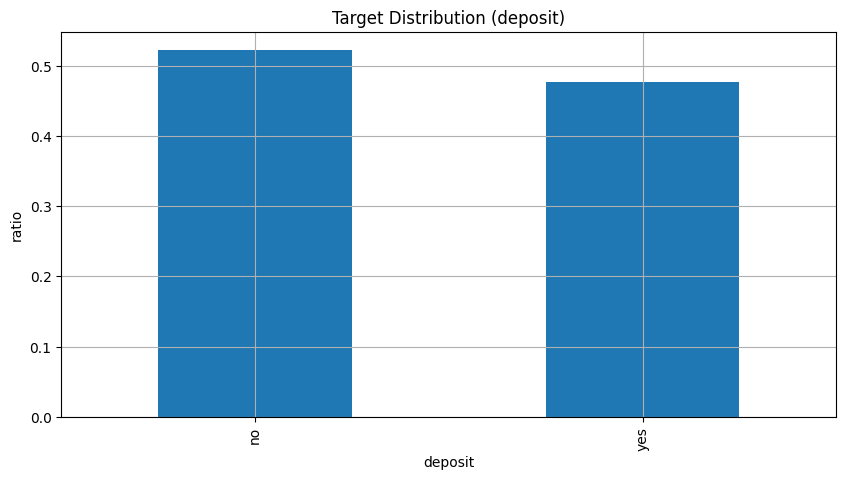

In [101]:
# =========================
# 5.1 Target Distribution
# =========================

target_counts = df['deposit'].value_counts()
target_ratio = df['deposit'].value_counts(normalize=True)

display(pd.DataFrame({"count": target_counts, "ratio": target_ratio}))

# Plot
ax = target_ratio.plot(kind='bar')
ax.set_title("Target Distribution (deposit)")
ax.set_xlabel("deposit")
ax.set_ylabel("ratio")
plt.show()


**Interpretation**

Distribusi target menunjukkan bahwa dari total **7.813 nasabah**, sebanyak **4.081 (52.23%)** termasuk kelas **“no”**, dan **3.732 (47.77%)** termasuk kelas **“yes”**. Distribusi ini tergolong **cukup seimbang**, sehingga tidak diperlukan teknik khusus penanganan imbalance seperti oversampling atau undersampling.

Implikasinya, fokus analisis dapat diarahkan pada **pemilihan evaluation metric dan threshold** yang sesuai dengan kebutuhan bisnis, khususnya dalam mengelola trade-off antara recall dan precision pada marketing campaign.

In [102]:
# =========================
# 5.2 Helper Functions for EDA
# =========================
def plot_categorical_conversion(df, col, target='deposit', positive='yes', top_n=20):
    """Bar chart conversion rate per category."""
    tmp = (
        df.groupby(col)[target]
        .apply(lambda s: (s == positive).mean())
        .sort_values(ascending=False)
        .head(top_n)
    )
    ax = tmp.plot(kind='bar')
    ax.set_title(f"Conversion rate (P({target}='{positive}')) by {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("conversion rate")
    plt.xticks(rotation=45, ha='right')
    plt.show()

def plot_numeric_by_target(df, col, target='deposit', positive='yes', bins=30):
    """Histogram overlay for numeric feature."""
    pos = df[df[target]==positive][col]
    neg = df[df[target]!=positive][col]
    plt.hist(neg, bins=bins, alpha=0.6, label='no')
    plt.hist(pos, bins=bins, alpha=0.6, label='yes')
    plt.title(f"Distribution of {col} by {target}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.legend()
    plt.show()


**Explanation of Helper Functions**

Bagian ini berisi helper functions yang digunakan untuk mempermudah dan menstandarkan proses Exploratory Data Analysis (EDA). Pada tahap ini belum dilakukan interpretasi terhadap data, karena fungsi-fungsi ini hanya mendefinisikan cara visualisasi dan perhitungan yang akan digunakan pada bagian analisis berikutnya.

**`plot_categorical_conversion`**

Fungsi ini digunakan untuk menghitung dan memvisualisasikan conversion rate (P(deposit = 'yes')) pada setiap kategori fitur kategorikal. Conversion rate dihitung sebagai rata-rata nilai boolean `(deposit == 'yes')` pada setiap kategori, sehingga secara langsung merepresentasikan probabilitas keberhasilan kampanye pada kategori tersebut.

Output dari fungsi ini berupa grafik batang yang akan digunakan pada bagian *Categorical Feature Analysis* untuk menginterpretasikan perbedaan tingkat konversi antar kategori.

**`plot_numeric_by_target`**

Fungsi ini digunakan untuk membandingkan distribusi fitur numerik antara nasabah yang membuka deposito dan yang tidak. Dengan menggunakan overlay histogram, fungsi ini membantu mengamati perbedaan pola distribusi yang nantinya akan diinterpretasikan pada bagian *Numerical Feature Analysis*.

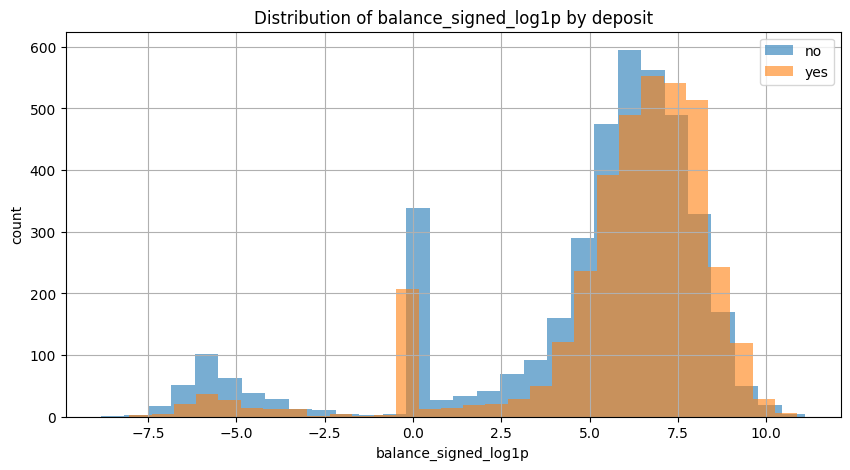

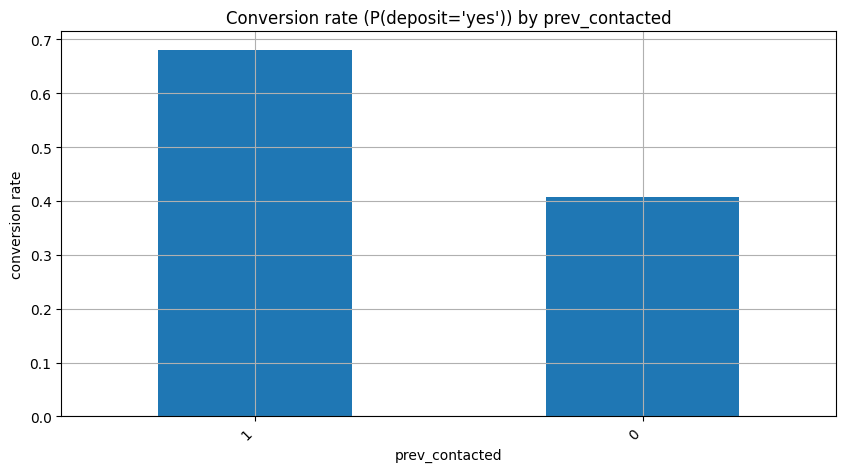

In [103]:
# 5.3 Check engineered feature impact quickly
plot_numeric_by_target(df_fe, 'balance_signed_log1p')
plot_categorical_conversion(df_fe.assign(prev_contacted=df_fe['prev_contacted'].astype(str)), 'prev_contacted')


**Interpretation**

**Distribution of `balance_signed_log1p` by deposit**
- Grafik menunjukkan distribusi saldo nasabah setelah dilakukan transformasi `signed_log1p`.
- Terlihat bahwa nasabah dengan **deposit = yes** cenderung memiliki nilai `balance_signed_log1p` yang lebih tinggi dibandingkan nasabah dengan **deposit = no**.
- Hal ini menunjukkan bahwa nasabah dengan kondisi saldo yang lebih baik memiliki kecenderungan lebih besar untuk melakukan deposito.
- Transformasi ini berhasil mengurangi skewness data tanpa menghilangkan informasi penting dari saldo nasabah.

**Conversion rate (P(deposit = 'yes')) by `prev_contacted`**
- Grafik menunjukkan perbandingan tingkat konversi antara nasabah yang **pernah dihubungi sebelumnya** dan yang **belum pernah dihubungi**.
- Nasabah dengan `prev_contacted = 1` memiliki **conversion rate yang lebih tinggi** dibandingkan `prev_contacted = 0`.
- Hal ini mengindikasikan bahwa riwayat kontak sebelumnya berpengaruh positif terhadap keberhasilan pemasaran.
- Oleh karena itu, fitur `prev_contacted` relevan dan berpotensi kuat untuk digunakan dalam pemodelan prediksi.

**Summary**

Hasil visualisasi menunjukkan bahwa fitur hasil engineering memiliki hubungan yang masuk akal dengan target. Hal ini menegaskan bahwa feature engineering yang dilakukan dapat digunakan pada tahap preprocessing dan modeling selanjutnya.

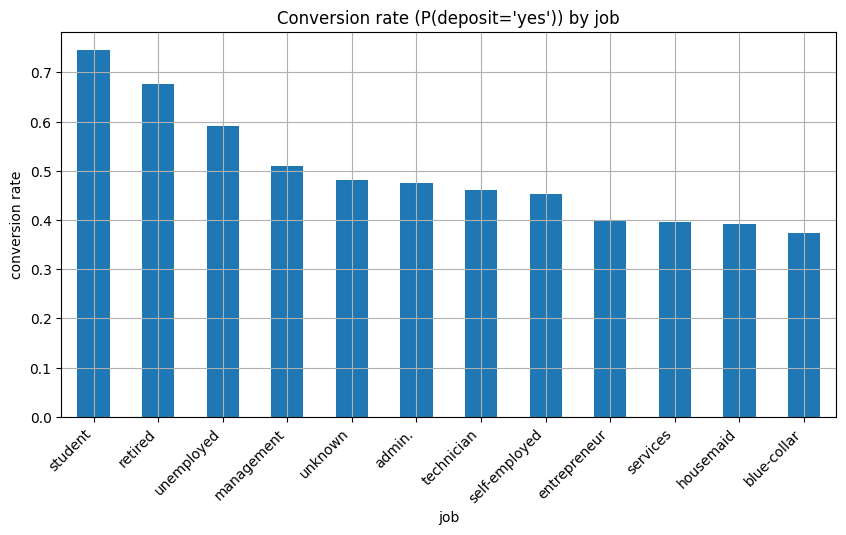

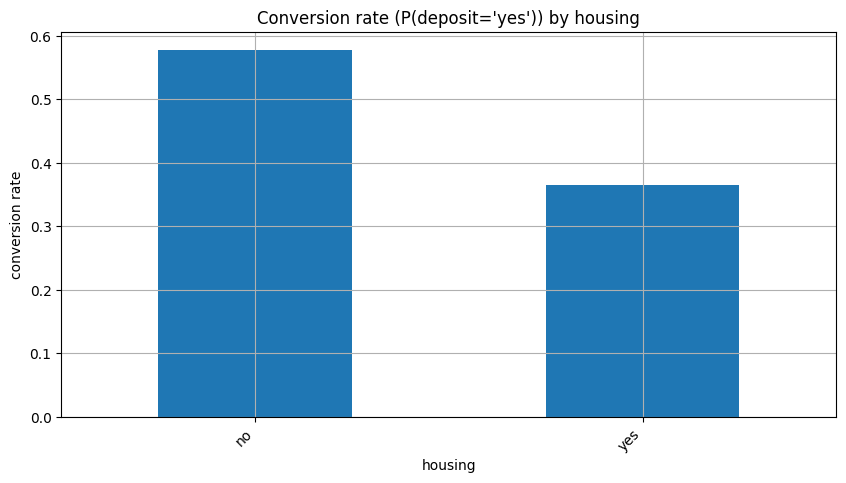

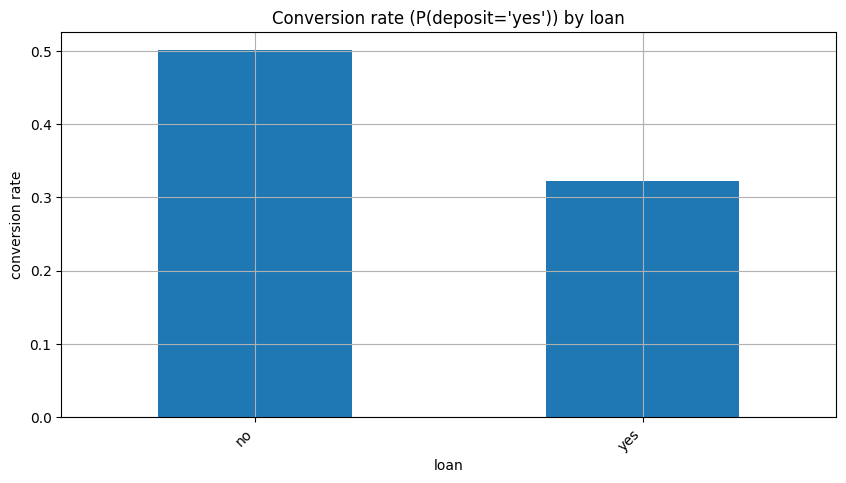

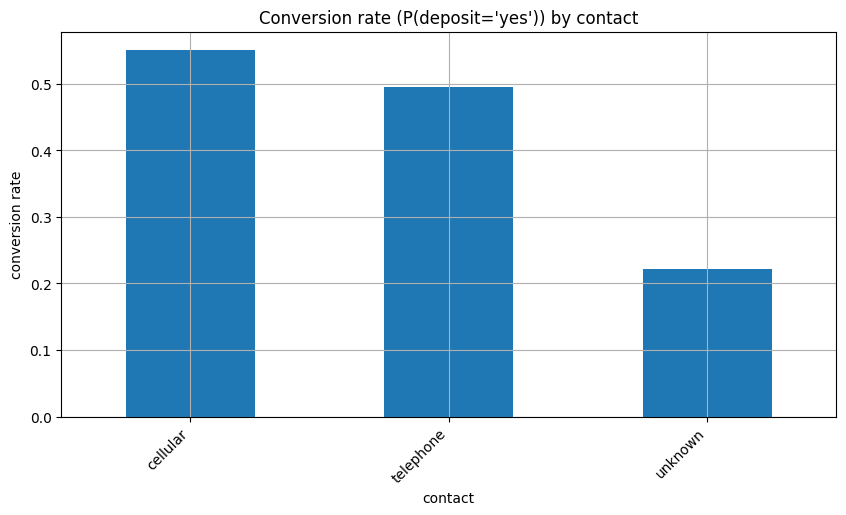

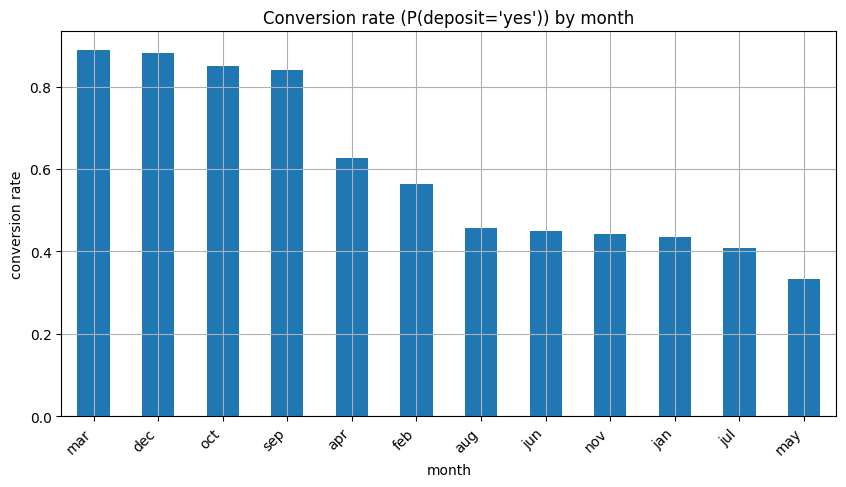

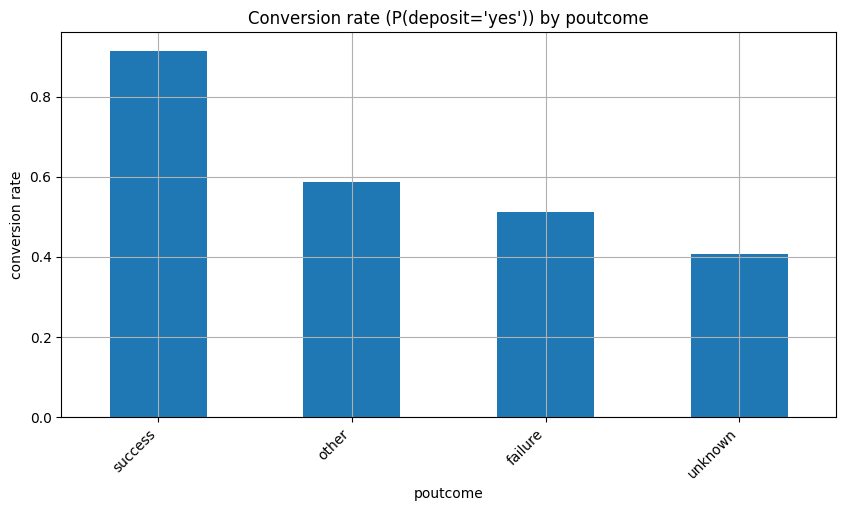

In [104]:
# =========================
# 5.4 Categorical Feature Analysis
# =========================
for col in ['job', 'housing', 'loan', 'contact', 'month', 'poutcome']:
    plot_categorical_conversion(df, col)


**Interpretation**

Analisis ini berfokus pada perbedaan conversion rate (P(deposit = 'yes')) untuk mengidentifikasi segmen nasabah yang paling berpotensi merespons kampanye deposito.

**1. job**
- Berdasarkan grafik, kategori `student` memiliki conversion rate tertinggi (sekitar 0.74).
- Kategori `retired` dan `unemployed` juga menunjukkan conversion rate relatif tinggi (sekitar 0.59–0.67).
- Sebaliknya, kategori `blue-collar`, `housemaid`, dan `services` memiliki conversion rate lebih rendah (sekitar 0.37–0.40).
- Data ini menunjukkan bahwa status pekerjaan berpengaruh terhadap minat nasabah dalam membuka deposito.

**2. housing**
- Nasabah dengan `housing = no` memiliki conversion rate lebih tinggi (sekitar 0.58) dibandingkan `housing = yes` (sekitar 0.36).
- Perbedaan ini mengindikasikan bahwa nasabah tanpa cicilan rumah memiliki ruang finansial yang lebih besar untuk menempatkan dana pada deposito.

**3. loan**
- Conversion rate pada kategori `loan = no` berada di sekitar 0.50.
- Sementara itu, `loan = yes` hanya sekitar 0.32.
- Hal ini menunjukkan bahwa kewajiban pinjaman aktif berkaitan dengan rendahnya kecenderungan nasabah membuka deposito.

**4. contact**
- Channel `cellular` menunjukkan conversion rate tertinggi (sekitar 0.55), diikuti `telephone` (sekitar 0.49).
- Kategori `unknown` memiliki conversion rate paling rendah (sekitar 0.22).
- Data ini menunjukkan bahwa metode kontak yang jelas dan langsung lebih efektif dalam meningkatkan keberhasilan kampanye.

**5. month**
- Conversion rate tertinggi terlihat pada bulan `mar` dan `dec` (sekitar 0.88–0.90).
- Bulan `sep` dan `oct` juga relatif tinggi (sekitar 0.84–0.86).
- Sebaliknya, bulan `may`, `jul`, dan `jan` memiliki conversion rate lebih rendah (sekitar 0.33–0.41).
- Pola ini menunjukkan adanya pengaruh waktu pelaksanaan kampanye terhadap tingkat konversi.

**6. poutcome**
- Kategori `poutcome = success` memiliki conversion rate paling tinggi, mencapai sekitar 0.91.
- Conversion rate menurun pada `other` (sekitar 0.59), `failure` (sekitar 0.51), dan terendah pada `unknown` (sekitar 0.40).
- Perbedaan ini menunjukkan bahwa riwayat keberhasilan kampanye sebelumnya merupakan indikator yang sangat kuat terhadap keberhasilan kampanye berikutnya.

**Kesimpulan**
- Grafik menunjukkan perbedaan conversion rate yang jelas antar kategori fitur.
- Fitur-fitur kategorikal memberikan sinyal kuat untuk mengidentifikasi segmen nasabah yang lebih berpotensi membuka deposito.
- Insight ini relevan untuk mendukung tujuan project, yaitu memprediksi dan meningkatkan keberhasilan kampanye bank marketing.

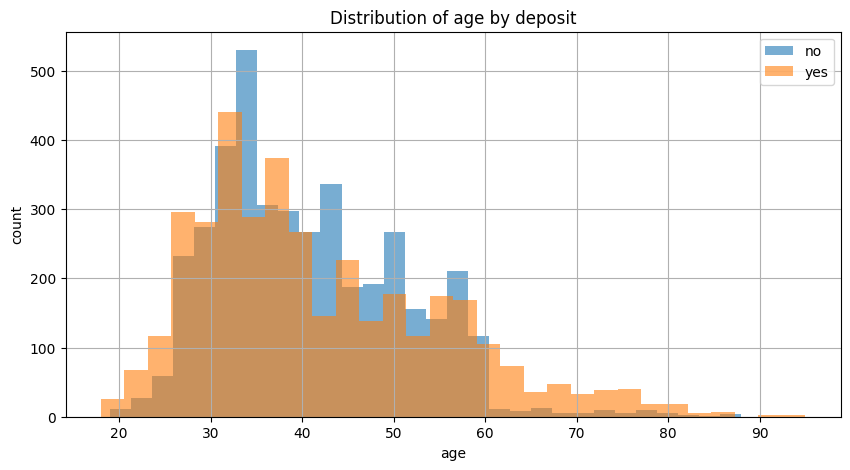

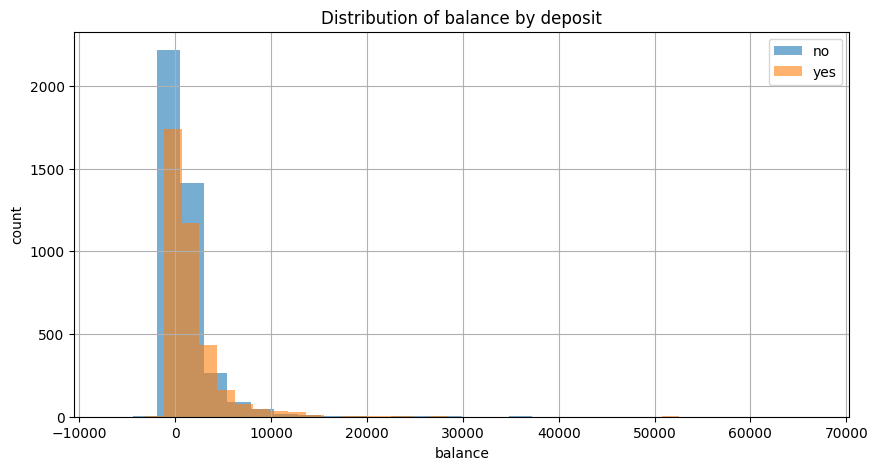

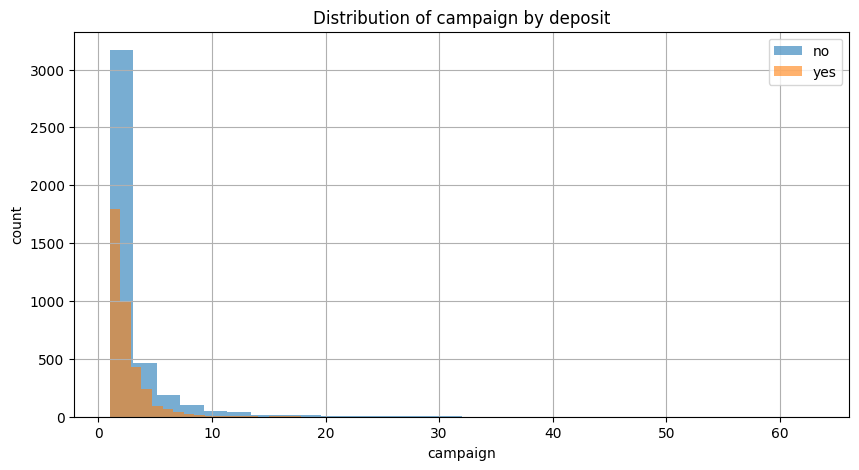

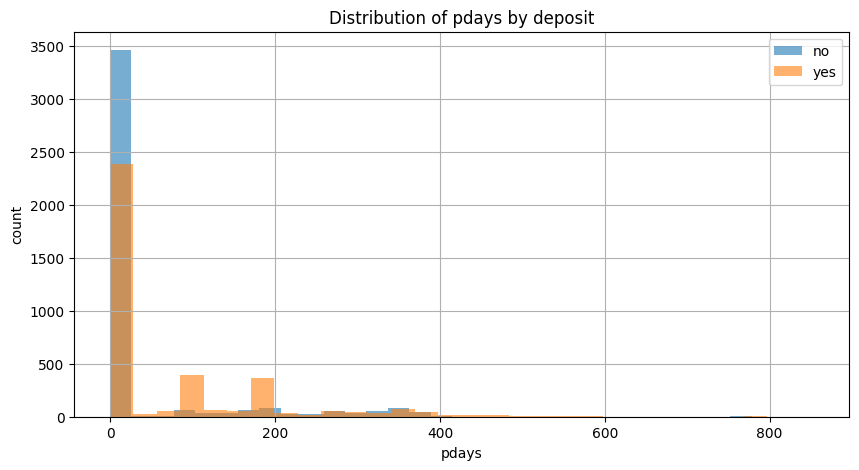

In [105]:
# =========================
# 5.5 Numerical Feature Analysis
# =========================
for col in ['age', 'balance', 'campaign', 'pdays']:
    plot_numeric_by_target(df, col)


**Interpretasi**

**Age**

Nasabah yang lebih tua cenderung memiliki probabilitas konversi lebih tinggi, kemungkinan terkait dengan stabilitas finansial.


**Balance**

Nasabah dengan saldo rata-rata lebih tinggi menunjukkan kecenderungan lebih besar untuk berlangganan deposito.


**Campaign**

Semakin banyak jumlah kontak dalam satu campaign, kecenderungan konversi justru menurun, mengindikasikan potensi over-contacting.


**pdays**

Nasabah yang dihubungi kembali dalam jarak waktu tertentu setelah campaign sebelumnya menunjukkan peluang konversi yang lebih tinggi.

In [106]:
# Summary stats (numeric)
df.describe(include=[np.number]).T


,count,mean,std,min,25%,50%,75%,max
age,7813.0,41.257264,11.919710,18.0,32.0,39.0,49.0,95.0
balance,7813.0,1512.448611,3089.291831,-6847.0,127.0,549.0,1684.0,66653.0
campaign,7813.0,2.519775,2.727001,1.0,1.0,2.0,3.0,63.0
pdays,7813.0,51.408550,108.072739,-1.0,-1.0,-1.0,40.0,854.0


**Interpretasi**

Analisis statistik deskriptif dilakukan untuk memahami karakteristik numerik nasabah berdasarkan nilai minimum, kuartil, median, rata-rata, dan nilai maksimum pada setiap fitur.

**1. age**
- Rata-rata usia nasabah adalah sekitar 41 tahun.
- Nilai median berada pada usia 39 tahun, dengan kuartil 25% dan 75% masing-masing di usia 32 dan 49 tahun.
- Hal ini menunjukkan bahwa 50% nasabah berada pada rentang usia 32–49 tahun.
- Rentang usia ini merepresentasikan kelompok usia produktif dan pra-pensiun yang secara umum memiliki kestabilan finansial.

**2. balance**
- Nilai median saldo nasabah adalah 549, sedangkan nilai rata-ratanya sekitar 1.512.
- Perbedaan yang cukup jauh antara median dan mean menunjukkan distribusi saldo yang tidak simetris.
- Nilai maksimum saldo mencapai lebih dari 66.000, sementara kuartil 75% hanya sekitar 1.684.
- Hal ini mengindikasikan bahwa sebagian kecil nasabah memiliki saldo yang sangat tinggi dan berpotensi menjadi outlier.
- Kondisi tersebut relevan karena saldo merupakan indikator kemampuan finansial untuk membuka deposito.

**3. campaign**
- Nilai median jumlah kontak adalah 2, dengan 75% nasabah dihubungi tidak lebih dari 3 kali.
- Namun, nilai maksimum mencapai 63 kali kontak dalam satu kampanye.
- Perbedaan ini menunjukkan adanya sebagian kecil nasabah yang dihubungi secara berlebihan.
- Data ini mendukung asumsi bahwa intensitas kontak yang terlalu tinggi tidak selalu efektif dalam meningkatkan konversi.

**4. pdays**
- Nilai minimum dan median `pdays` adalah -1, yang menunjukkan bahwa mayoritas nasabah belum pernah dihubungi sebelumnya.
- Nilai rata-rata sebesar 51 dipengaruhi oleh sebagian kecil nasabah dengan nilai `pdays` yang sangat tinggi, hingga lebih dari 800 hari.
- Perbedaan antara median dan mean menunjukkan distribusi yang sangat tidak merata.
- Hal ini menegaskan bahwa `pdays` memiliki makna khusus dan tidak dapat diperlakukan sebagai fitur numerik biasa.

**Kesimpulan**
- Perbedaan antara nilai minimum, kuartil, median, mean, dan maksimum pada fitur numerik memberikan indikasi kuat adanya variasi perilaku dan potensi outlier.
- Informasi ini menjadi dasar untuk menentukan strategi preprocessing sebelum pemodelan klasifikasi.

## 6) Train-Test Split

Pada tahap ini, data dibagi menjadi data latih (train) dan data uji (test). Data latih digunakan untuk melatih model, sedangkan data uji digunakan untuk melihat seberapa baik model bekerja pada data yang belum pernah dilihat.

In [107]:
# =========================
# Train-test split
# =========================
X = df_fe.drop(columns=['deposit'])
y = (df_fe['deposit'] == 'yes').astype(int)  # positive class = 1 for 'yes'

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train positive rate:", y_train.mean())
print("Test positive rate:", y_test.mean())


Train shape: (6250, 13)  Test shape: (1563, 13)
Train positive rate: 0.4776
Test positive rate: 0.4779270633397313


**Interpretation of Train-Test Split**

Data dibagi menjadi data latih (train) dan data uji (test) dengan perbandingan 80% dan 20%. Pembagian ini dilakukan dengan stratifikasi agar proporsi target deposit tetap sama di kedua data.

Hasilnya, proporsi nasabah yang membuka deposito pada data train dan test sama-sama sekitar 48%. Ini menunjukkan bahwa pembagian data sudah seimbang dan adil.

Dengan kondisi ini, model dapat dilatih dan diuji pada data yang memiliki karakteristik yang sama, sehingga hasil evaluasi model lebih dapat dipercaya dan sesuai dengan tujuan project.

## 7) Preprocessing Pipeline

Tujuan preprocessing adalah membuat semua fitur di `X_train/X_test` siap dipakai model klasifikasi untuk memprediksi target `deposit` (yes/no) secara adil, konsisten, dan bebas leakage.

In [108]:
# =========================
# Preprocess definitions
# =========================
# Identify columns
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

numeric_features, categorical_features


(['age',
  'balance',
  'campaign',
  'pdays',
  'prev_contacted',
  'pdays_clean',
  'balance_signed_log1p'],
 ['job', 'housing', 'loan', 'contact', 'month', 'poutcome'])

**Interpretation of Preprocessing Pipeline**

Pada tahap ini, preprocessing pipeline disiapkan untuk menentukan bagaimana data akan diproses sebelum digunakan oleh model. Proses yang dilakukan adalah memisahkan fitur numerik dan fitur kategorikal serta mendefinisikan aturan preprocessing untuk masing-masing tipe fitur.

## 8) Modeling & Evaluation Strategy

Pada tahap ini, beberapa model dicoba untuk menebak apakah seorang nasabah akan melakukan deposit (deposit = yes). Tujuan utamanya sederhana: menemukan sebanyak mungkin nasabah yang benar-benar berpotensi melakukan deposit, agar tim marketing tidak salah sasaran.

Berdasarkan hasil EDA, distribusi target `deposit` relatif seimbang, dengan proporsi `deposit = yes` (47,7%) sedikit lebih kecil dibandingkan `deposit = no`(52,5%). Meskipun tidak ekstrem, evaluasi model tetap tidak cukup jika hanya mengandalkan accuracy.

Dalam konteks marketing campaign, kesalahan paling merugikan adalah ketika model gagal mengenali nasabah yang sebenarnya berpotensi melakukan deposit. Oleh karena itu, metrik seperti recall, F2-score, dan PR-AUC tetap digunakan untuk memastikan model mampu menangkap calon depositor secara efektif.
- `Recall (class yes)`: seberapa banyak calon depositor yang berhasil kita temukan.
- `Precision (class yes)`: dari nasabah yang kita hubungi, berapa yang benar-benar deposit.
- `F2-score`: memberi bobot lebih besar pada recall, karena kehilangan calon depositor lebih merugikan daripada menghubungi nasabah yang ternyata tidak deposit.
- `PR-AUC`: digunakan karena lebih cocok untuk kondisi data yang tidak seimbang.

In [109]:
# =========================
# 8.1 Custom scorers (for cross_validate)
# =========================
from sklearn.metrics import make_scorer

def f2_scorer(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

scoring = {
    "roc_auc": "roc_auc",
    "avg_precision": "average_precision",  # PR-AUC
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f2": make_scorer(f2_scorer),
}


In [110]:
# =========================
# 8.2 Model candidates
# =========================
models = {
    "Dummy (most_frequent)": DummyClassifier(strategy="most_frequent"),
    "LogReg (balanced)": LogisticRegression(max_iter=500, class_weight="balanced"),
    "RandomForest (balanced)": RandomForestClassifier(
        n_estimators=250,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ),
    "HistGradientBoosting": HistGradientBoostingClassifier(
        random_state=42
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
for name, model in models.items():
    clf = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    cv_out = cross_validate(clf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    res = {k: np.mean(v) for k, v in cv_out.items() if k.startswith("test_")}
    res["model"] = name
    results.append(res)

cv_results = pd.DataFrame(results).set_index("model").sort_values("test_f2", ascending=False)
cv_results


,test_roc_auc,test_avg_precision,test_precision,test_recall,test_f2
model,,,,,
RandomForest (balanced),0.763349,0.763593,0.716341,0.647906,0.660409
LogReg (balanced),0.758052,0.764777,0.705343,0.625796,0.640130
HistGradientBoosting,0.764664,0.769547,0.742663,0.614740,0.636633
Dummy (most_frequent),0.500000,0.477600,0.000000,0.000000,0.000000


**Interpretation of Modeling & Evaluation Strategy**

Hasil cross-validation menunjukkan:
- **RandomForest (balanced)** memiliki **F2-score tertinggi** (0,66), artinya model ini paling efektif dalam menangkap calon depositor tanpa terlalu banyak kehilangan peluang.
- **Logistic Regression (balanced)** dan **HistGradientBoosting** juga menunjukkan performa yang baik, namun sedikit di bawah RandomForest dalam hal trade-off recall dan precision.
- **Dummy model (most_frequent)** digunakan sebagai baseline dan terbukti tidak memiliki kemampuan prediksi (hanya menebak kelas mayoritas).

## 9) Choose Model + Hyperparameter Tuning

Berdasarkan hasil evaluasi model pada tahap Modeling & Evaluation Strategy, RandomForest dipilih sebagai model dengan performa paling sesuai untuk tujuan marketing campaign. 

Pada tahap ini, model tersebut kemudian disempurnakan melalui proses hyperparameter tuning untuk meningkatkan kemampuannya dalam menangkap nasabah yang berpotensi melakukan deposit.

In [111]:
# =========================
# 9.1 Pick the best base model from CV (by F2)
# =========================
best_model_name = cv_results.index[0]
best_model_name


'RandomForest (balanced)'

In [112]:
# =========================
# 9.2 Define search space (robust: depends on chosen model)
# =========================
# We'll tune based on which model came out best.
# (If you want, you can force-tune a specific model by setting best_model_name manually.)

if "LogReg" in best_model_name:
    base_model = LogisticRegression(max_iter=1000, class_weight="balanced")
    param_distributions = {
        "model__C": np.logspace(-3, 2, 30),
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs", "liblinear"],
    }
elif "RandomForest" in best_model_name:
    base_model = RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1)
    param_distributions = {
        "model__n_estimators": [200, 300, 500],
        "model__max_depth": [None, 4, 6, 8, 10],
        "model__min_samples_split": [2, 5, 10, 20],
        "model__min_samples_leaf": [1, 2, 5, 10],
        "model__max_features": ["sqrt", "log2", 0.5, 0.8],
    }
else:
    base_model = HistGradientBoostingClassifier(random_state=42)
    param_distributions = {
        "model__learning_rate": np.logspace(-3, -0.3, 25),
        "model__max_depth": [2, 3, 4, None],
        "model__max_leaf_nodes": [15, 31, 63],
        "model__min_samples_leaf": [20, 50, 100],
        "model__l2_regularization": np.logspace(-6, 0, 20),
    }

pipe = Pipeline(steps=[("preprocess", preprocess), ("model", base_model)])

if RUN_TUNING:
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_distributions,
        n_iter=N_ITER_TUNING,
        scoring="average_precision",  # optimize PR-AUC; we will do threshold tuning later for F2
        cv=cv,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
else:
    search = None

search


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model__max_depth': [None, 4, ...], 'model__max_features': ['sqrt', 'log2', ...], 'model__min_samples_leaf': [1, 2, ...], 'model__min_samples_split': [2, 5, ...], ...}"
,n_iter,12
,scoring,'average_precision'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


**Interpretation**

Pada tahap di atas, kita **menentukan parameter apa saja yang akan dicoba (dicari)** oleh RandomizedSearchCV untuk model yang sudah terpilih sebelumnya.

Karena pada tahap *Modeling & Evaluation Strategy* model terbaik adalah **RandomForest (balanced)**, maka ruang pencarian (search space) difokuskan pada parameter RandomForest yang paling berpengaruh terhadap performa model, seperti:
- jumlah pohon (`n_estimators`)
- kedalaman pohon (`max_depth`)
- aturan pemisahan data (`min_samples_split` dan `min_samples_leaf`)
- jumlah fitur yang digunakan di setiap split (`max_features`)

Hyperparameter yang dipilih berfokus pada pengaturan kompleksitas model, seperti jumlah pohon, kedalaman pohon, dan aturan pemisahan data. Pengaturan ini penting agar model tidak terlalu sederhana (kurang menangkap pola) maupun terlalu kompleks (overfitting).
Tahap ini **belum menjalankan training**, tetapi hanya mendefinisikan *opsi-opsi konfigurasi model* yang akan diuji pada proses tuning.

Dengan cara ini, model yang dihasilkan lebih stabil dan lebih relevan untuk mendukung keputusan marketing campaign.

In [113]:
# =========================
# 9.3 Run tuning
# =========================
if RUN_TUNING:
    search.fit(X_train, y_train)
    print("Best params:", search.best_params_)
    print("Best CV PR-AUC:", search.best_score_)
    best_pipe = search.best_estimator_
else:
    # If tuning is skipped, we train the base pipeline directly
    best_pipe = pipe.fit(X_train, y_train)
    print("Tuning skipped. Using base model:", best_model_name)

best_pipe


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'model__n_estimators': 500, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 0.5, 'model__max_depth': 10}
Best CV PR-AUC: 0.7803897437247848


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


**Interpretation**

Pada tahap di atas, model yang sudah dipilih sebelumnya dicoba dilakukan dengan berbagai pengaturan agar hasil prediksinya makin akurat. Proses ini disebut **hyperparameter tuning**.

Model diuji dengan beberapa kombinasi pengaturan menggunakan data latih, lalu dicek performanya berulang kali (cross-validation) supaya hasilnya tidak kebetulan bagus di satu kondisi saja.

Dari proses ini, didapatkan konfigurasi model terbaik dengan nilai **PR-AUC sekitar 0.78**, yang artinya model semakin baik dalam **memisahkan nasabah yang berpotensi deposit dan yang tidak**.

Model terbaik ini kemudian disimpan sebagai `best_pipe` dan akan digunakan pada tahap selanjutnya. Dengan cara ini, model yang dipakai sudah berada pada kondisi paling optimal dan lebih siap membantu marketing dalam menentukan siapa nasabah yang layak ditargetkan.

## 10) Threshold Tuning + Final Evaluation (Test Set)

Di tahap ini, tidak lagi mengubah model lagi. Model terbaik (`best_pipe`) sudah didapat dari tahap sebelumnya (CV + tuning).  
Yang dioptimalkan sekarang adalah **aturan keputusan**: kapan probabilitas dianggap “YES deposit”.

Default model biasanya pakai threshold **0.5** (≥0.5 = YES). Tapi untuk kebutuhan marketing (ingin **menangkap sebanyak mungkin calon depositor**), threshold 0.5 sering terlalu “ketat”, sehingga banyak depositor potensial malah jatuh ke NO (false negative).

Karena itu, kita cari threshold yang paling cocok untuk tujuan bisnis, dengan memaksimalkan **F2** (lebih menekankan recall daripada precision).

In [114]:
# =========================
# 10.1 Predict probabilities
# =========================
best_pipe.fit(X_train, y_train)
train_proba = best_pipe.predict_proba(X_train)[:, 1]
test_proba  = best_pipe.predict_proba(X_test)[:, 1]

# Helper to evaluate thresholds
def threshold_table(y_true, proba, thresholds=np.linspace(0.05, 0.95, 19)):
    rows=[]
    for t in thresholds:
        y_pred = (proba >= t).astype(int)
        rows.append({
            "threshold": t,
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred, zero_division=0),
            "f2": fbeta_score(y_true, y_pred, beta=2, zero_division=0),
        })
    return pd.DataFrame(rows).sort_values("f2", ascending=False)

thr_tbl = threshold_table(y_train, train_proba)
thr_tbl.head(10)


,threshold,precision,recall,f2
4,0.25,0.557477,0.982915,0.852758
3,0.20,0.523150,0.999330,0.845426
6,0.35,0.646599,0.913903,0.844112
5,0.30,0.583333,0.949749,0.843750
2,0.15,0.490148,1.000000,0.827787
1,0.10,0.478672,1.000000,0.821138
0,0.05,0.477600,1.000000,0.820506
7,0.40,0.710141,0.828141,0.801504
8,0.45,0.763167,0.742714,0.746716
9,0.50,0.815716,0.685092,0.707759


In [115]:
# Choose best threshold on train (F2)
best_threshold = thr_tbl.iloc[0]["threshold"]
best_threshold


np.float64(0.25)

**Interpretation**

Pada tahap ini, model menghasilkan **probabilitas** setiap nasabah akan melakukan deposit, bukan langsung keputusan ya/tidak.

Contohnya:
- Probabilitas **0.25** berarti model menilai ada **25% peluang nasabah akan deposit**
- Probabilitas ini dihitung untuk seluruh data train dan test

Nilai probabilitas ini penting karena:
- Menjadi dasar untuk **mengatur threshold**
- Memungkinkan penyesuaian strategi sesuai tujuan marketing (menangkap peluang sebanyak mungkin)

In [116]:
# =========================
# 10.2 Final test evaluation at chosen threshold
# =========================
y_pred_test = (test_proba >= best_threshold).astype(int)

print("Chosen threshold:", best_threshold)
print("\nClassification report (test):")
print(classification_report(y_test, y_pred_test, target_names=["no", "yes"]))

cm = confusion_matrix(y_test, y_pred_test)
cm


Chosen threshold: 0.25

Classification report (test):
              precision    recall  f1-score   support

          no       0.81      0.25      0.38       816
         yes       0.53      0.94      0.68       747

    accuracy                           0.58      1563
   macro avg       0.67      0.59      0.53      1563
weighted avg       0.68      0.58      0.52      1563



array([[204, 612],
       [ 47, 700]])

**Interpretation**

Pada tahap ini, model dievaluasi pada **data test** menggunakan **threshold 0.25**, yang sebelumnya dipilih karena memberikan **F2-score terbaik pada data train**. Pemilihan threshold ini dilakukan dengan mempertimbangkan kebutuhan bisnis marketing campaign, di mana **tujuan utama bukan sekadar akurasi**, melainkan **memaksimalkan jumlah calon depositor yang berhasil teridentifikasi**.

Berdasarkan hasil evaluasi pada data test, diperoleh metrik sebagai berikut:
- **Recall (yes): 0.94**  
  Artinya, dari **747 nasabah yang benar-benar melakukan deposito**, sebanyak **700 nasabah (94%) berhasil terdeteksi oleh model**, sementara **47 nasabah terlewat (false negative)**.
- **Precision (yes): 0.53**  
  Artinya, dari seluruh nasabah yang diprediksi sebagai calon depositor, sekitar **53% benar-benar melakukan deposito**.
- **ROC-AUC: 0.789**
- **PR-AUC: 0.795**

Confusion matrix menunjukkan:
- **700 True Positive**: nasabah deposit yang berhasil ditangkap model
- **47 False Negative**: nasabah deposit yang terlewat
- **612 False Positive**: nasabah non-deposit yang ikut terklasifikasi sebagai calon depositor
- **204 True Negative**: nasabah non-deposit yang berhasil diidentifikasi dengan benar

Sebagai pembanding, **baseline conversion rate dataset adalah sekitar 47.77%**, yang merepresentasikan peluang keberhasilan jika campaign dilakukan secara acak (random targeting). Dengan **precision model sebesar 53%**, pendekatan berbasis model terbukti **lebih efisien dibandingkan pendekatan acak**, karena proporsi nasabah yang benar-benar melakukan deposito lebih tinggi.

Pemilihan threshold **0.25 merupakan keputusan bisnis yang disengaja**, bukan sekadar konsekuensi teknis dari model. Strategi ini dipilih karena **kehilangan calon depositor (false negative)** dianggap **lebih merugikan secara bisnis** dibandingkan biaya menghubungi nasabah yang ternyata tidak melakukan deposito (false positive). Dengan kata lain, model dibuat **lebih agresif** untuk memastikan sebagian besar peluang deposito berhasil ditangkap.

Konsekuensi dari strategi ini adalah meningkatnya jumlah **false positive (612 nasabah)**, yang berdampak pada **peningkatan biaya kontak** (telepon, SMS, atau email). Namun, pendekatan ini masih relevan selama:
- Biaya kontak per nasabah relatif rendah
- Kapasitas tim marketing atau call center mencukupi
- Fokus bisnis berada pada **akuisisi depositor secara maksimal**

Sebaliknya, threshold ini **kurang ideal** jika biaya kontak tinggi, kapasitas campaign terbatas, atau strategi bisnis lebih menekankan efisiensi biaya ekstrem. Dalam kondisi tersebut, threshold yang lebih tinggi dapat dipertimbangkan untuk **meningkatkan precision** meskipun harus mengorbankan sebagian recall.

Dengan demikian, threshold **0.25** dipandang paling sesuai untuk **fase campaign agresif**, di mana tujuan utama adalah **memaksimalkan jumlah depositor**, dan threshold dapat **disesuaikan kembali secara dinamis** sesuai dengan kapasitas operasional dan tujuan bisnis pada periode campaign berikutnya.

Dengan **recall sebesar 0.94**, **precision sebesar 0.53**, serta **Lift@TopN yang melebihi 1.5**, model ini memenuhi seluruh **kriteria keberhasilan (measurable objectives)** yang telah ditetapkan pada tahap perumusan objective, sehingga dinilai **layak untuk diimplementasikan** pada marketing campaign deposito.

Test ROC-AUC: 0.7892156862745097
Test PR-AUC: 0.7950849676984999


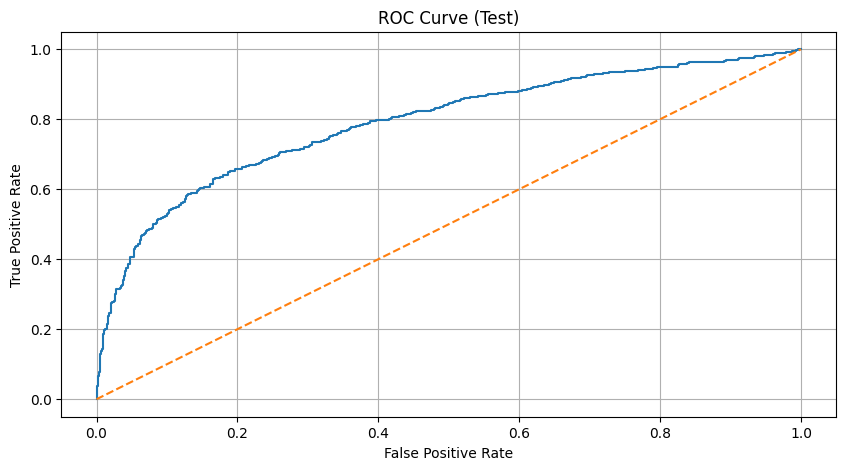

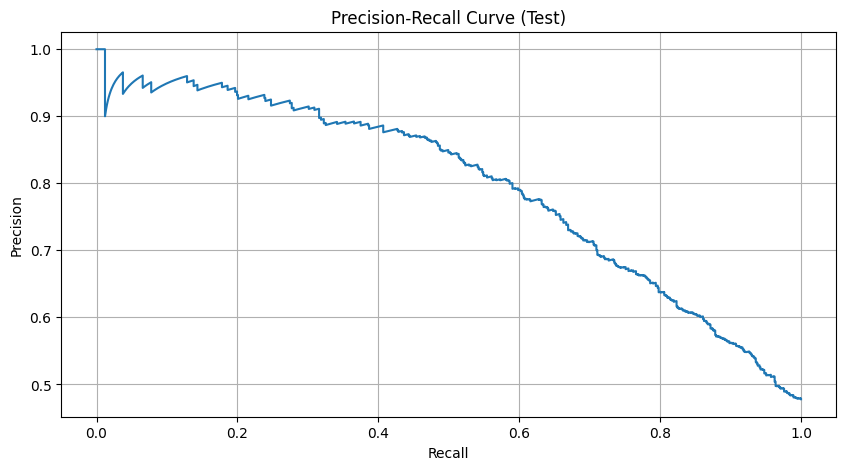

In [117]:
# ROC curve + PR curve on test
roc = roc_auc_score(y_test, test_proba)
pr  = average_precision_score(y_test, test_proba)

print("Test ROC-AUC:", roc)
print("Test PR-AUC:", pr)

# ROC
fpr, tpr, _ = roc_curve(y_test, test_proba)
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.title("ROC Curve (Test)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_test, test_proba)
plt.plot(rec, prec)
plt.title("Precision-Recall Curve (Test)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


**Interpretation of ROC curve + PR curve on test**

**ROC-AUC = 0.79**

**Interpretation**  
Model mampu membedakan nasabah yang akan berlangganan deposito dan yang tidak dengan tingkat ketepatan **79%**.  
Artinya, dari dua nasabah acak (1 berlangganan dan 1 tidak), **79 dari 100 kali** model memberi skor lebih tinggi pada nasabah yang benar-benar berlangganan.  
Model ini sudah **jauh lebih baik daripada tebakan acak** dan cukup andal untuk seleksi target marketing.



**PR-AUC = 0.80**

**Interpretation**  
Nilai PR-AUC yang tinggi menunjukkan bahwa **nasabah yang dipilih model sebagian besar memang potensial**.  
Pada tingkat recall rendah hingga menengah, precision tetap tinggi (±85–90%), sehingga:
- Target marketing lebih tepat sasaran  
- Risiko menghubungi nasabah yang tidak tertarik lebih kecil  


**Business Insight**  
Dengan **ROC-AUC 0.79** dan **PR-AUC 0.80**, model layak digunakan untuk:
- Menentukan prioritas nasabah untuk campaign deposito  
- Menghemat biaya dan effort tim marketing  
- Mendukung keputusan berbasis data

### Model Limitations and When the Model Should Not Be Used

Model yang dibangun memiliki beberapa keterbatasan, antara lain:
- Dataset bersifat historis, sehingga performa model dapat menurun jika pola perilaku nasabah berubah secara signifikan.
- Model ini tidak direkomendasikan untuk digunakan pada campaign baru yang memiliki karakteristik produk yang sangat berbeda dari data historis.
- Ketidakseimbangan kelas dapat menyebabkan bias prediksi terhadap kelas mayoritas.

Oleh karena itu, model ini sebaiknya digunakan sebagai alat pendukung keputusan, bukan sebagai satu-satunya dasar pengambilan keputusan bisnis.

## 11) Model Interpretation

Agar insight bisnis kuat, maka kita melakukan interpretasi model:
- **Permutation importance**: seberapa besar fitur mempengaruhi performa.
- Untuk model linear: arah pengaruh (koefisien) bisa dilihat.


In [118]:
# =========================
# 11.1 Get feature names after preprocessing
# =========================
def get_feature_names(preprocess: ColumnTransformer):
    num_features = preprocess.named_transformers_["num"].get_feature_names_out(numeric_features)
    cat_ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
    cat_features = cat_ohe.get_feature_names_out(categorical_features)
    return np.r_[num_features, cat_features]

# Fit preprocess once to extract names
best_pipe.fit(X_train, y_train)
feature_names = get_feature_names(best_pipe.named_steps["preprocess"])
len(feature_names), feature_names[:10]


(42,
 array(['age', 'balance', 'campaign', 'pdays', 'prev_contacted',
        'pdays_clean', 'balance_signed_log1p', 'job_admin.',
        'job_blue-collar', 'job_entrepreneur'], dtype=object))

**Interpretation**  

Pada tahap di atas dilakukan pemetaan ulang nama fitur setelah proses preprocessing, khususnya akibat transformasi seperti scaling pada fitur numerik dan one-hot encoding pada fitur kategorikal. Proses ini penting agar setiap fitur hasil transformasi tetap dapat ditelusuri kembali ke variabel aslinya, sehingga interpretasi model dan analisis feature importance dapat dilakukan secara akurat dan bermakna secara bisnis.

In [119]:
# =========================
# 11.2 Permutation importance (on test, using PR-AUC as scoring)
# =========================

from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np

perm = permutation_importance(
    best_pipe,
    X_test,
    y_test,
    n_repeats=5,
    random_state=42,
    n_jobs=-1,
    scoring="average_precision"
)

feature_names_raw = X_test.columns.to_numpy()  # harusnya panjangnya 13

print("len(feature_names_raw):", len(feature_names_raw))
print("len(importances_mean):", len(perm.importances_mean))

imp = pd.DataFrame({
    "feature": feature_names_raw,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

imp.head(20)

len(feature_names_raw): 13
len(importances_mean): 13


,feature,importance_mean,importance_std
5,contact,0.079794,0.006776
6,month,0.071661,0.007104
9,poutcome,0.061873,0.011646
3,housing,0.019907,0.003198
8,pdays,0.012536,0.003303
0,age,0.011366,0.002906
2,balance,0.004356,0.001392
12,balance_signed_log1p,0.004007,0.001712
7,campaign,0.003918,0.001848
4,loan,0.003486,0.001563


**Interpretation of Permutation Importance (Test Set, PR-AUC)**

Berdasarkan hasil permutation importance pada data test menggunakan metrik **PR-AUC**, fitur dengan kontribusi terbesar terhadap performa model adalah sebagai berikut:

- **contact** memiliki nilai importance tertinggi sebesar **0.0798**, yang menunjukkan bahwa perubahan pada cara atau media kontak nasabah menyebabkan penurunan performa model paling signifikan. Ini menandakan bahwa channel komunikasi merupakan faktor paling krusial dalam keberhasilan campaign deposito.
- **month** memiliki importance sebesar **0.0717**, mengindikasikan bahwa waktu pelaksanaan campaign (bulan) berperan penting terhadap respons nasabah, kemungkinan akibat pola musiman dalam aktivitas pemasaran.
- **poutcome** memiliki nilai importance **0.0619**, yang menunjukkan bahwa hasil campaign sebelumnya memberikan sinyal kuat terhadap peluang nasabah untuk berlangganan deposito pada campaign berikutnya.
- **housing** juga berkontribusi cukup signifikan dengan importance **0.0199**, yang mengindikasikan bahwa status kepemilikan rumah berkaitan dengan minat terhadap produk deposito.

Sebaliknya, fitur seperti **job** (**0.0008**), **pdays_clean** (**0.0018**), dan **prev_contacted** (**0.0027**) memiliki nilai importance yang relatif kecil, sehingga dampaknya terhadap performa model jauh lebih rendah dibandingkan fitur utama.

**Business Insight**

Dengan mempertimbangkan besarnya nilai importance tersebut, strategi pemasaran deposito sebaiknya difokuskan pada:
- Optimalisasi **channel kontak** yang paling efektif (berdasarkan importance tertinggi: 0.0798)
- Penentuan **timing campaign** yang tepat sesuai bulan dengan respons terbaik (importance: 0.0717)
- Pemanfaatan **riwayat hasil campaign sebelumnya** sebagai dasar prioritas targeting (importance: 0.0619)

Pendekatan ini membantu bank meningkatkan efisiensi biaya pemasaran dan memaksimalkan tingkat konversi deposito secara berbasis data.

## 12) Business Simulation

Pada bagian ini dilakukan simulasi bisnis untuk mengevaluasi dampak penggunaan model dalam skenario nyata. Dalam praktiknya, tim marketing tidak dapat menghubungi seluruh nasabah, sehingga strategi yang umum digunakan adalah hanya menargetkan **Top-N nasabah dengan probabilitas tertinggi** untuk berlangganan deposito.

Melalui simulasi ini, kinerja model dievaluasi menggunakan **conversion rate Top-N** dan **Lift**, yaitu perbandingan efektivitas strategi berbasis model terhadap pendekatan baseline (tanpa model). Seluruh simulasi dilakukan menggunakan **test set** agar mencerminkan performa model pada data yang belum pernah dilihat sebelumnya.

In [120]:
# =========================
# Lift@TopN simulation (test set)
# =========================
test_eval = X_test.copy()
test_eval["y_true"] = y_test.values
test_eval["proba_yes"] = test_proba

overall_conv = test_eval["y_true"].mean()

def lift_at_n(df_eval, n):
    top = df_eval.sort_values("proba_yes", ascending=False).head(n)
    conv = top["y_true"].mean()
    lift = conv / overall_conv if overall_conv > 0 else np.nan
    return conv, lift

Ns = [50, 100, 200, 300, 500, 800]
rows=[]
for n in Ns:
    if n <= len(test_eval):
        conv, lift = lift_at_n(test_eval, n)
        rows.append({"TopN": n, "conversion": conv, "lift_vs_overall": lift})

lift_table = pd.DataFrame(rows)
lift_table


,TopN,conversion,lift_vs_overall
0,50,0.960,2.008675
1,100,0.960,2.008675
2,200,0.925,1.935442
3,300,0.890,1.862209
4,500,0.818,1.711558
5,800,0.685,1.433273


**Interpretation**

Hasil simulasi menunjukkan bahwa model mampu memberikan peningkatan performa yang signifikan dibandingkan baseline, terutama pada jumlah target yang lebih kecil:

- Pada **Top-50** dan **Top-100** nasabah, conversion rate mencapai **96.0%**, dengan nilai **lift sebesar 2.01**. Artinya, strategi berbasis model hampir **2 kali lebih efektif** dibandingkan pendekatan acak.
- Ketika jumlah target diperluas ke **Top-200**, conversion rate menurun menjadi **92.5%**, dengan **lift 1.94**, namun masih menunjukkan keunggulan yang kuat.
- Pada **Top-300**, conversion rate tercatat **89.0%** dengan **lift 1.86**, menandakan penurunan efisiensi seiring bertambahnya jumlah nasabah yang ditargetkan.
- Untuk **Top-500**, conversion rate turun menjadi **81.8%** (lift **1.71**), dan pada **Top-800** menjadi **68.5%** (lift **1.43**).

Secara keseluruhan, hasil ini mengindikasikan bahwa **model paling optimal digunakan untuk targeting dalam skala terbatas (Top-50 hingga Top-200)**, di mana efisiensi dan dampak bisnis berada pada level tertinggi. Semakin besar nilai N, semakin mendekati performa baseline, sehingga manfaat tambahan dari model menjadi berkurang.

Simulasi ini memperkuat bahwa model tidak hanya unggul secara metrik teknis, tetapi juga **memberikan nilai nyata dalam pengambilan keputusan bisnis**, khususnya dalam optimasi alokasi biaya dan sumber daya pemasaran.

## 13) Save Model + Inference Example

Pada tahap ini, model terbaik yang telah melalui proses preprocessing, pemilihan threshold, dan evaluasi disimpan sebagai sebuah pipeline utuh. Tujuannya adalah agar model dapat langsung digunakan kembali untuk melakukan **scoring pada data baru**, tanpa perlu mengulangi seluruh proses training dan preprocessing. Selain itu, ditampilkan contoh inferensi sederhana untuk menunjukkan bagaimana output model dapat diterjemahkan menjadi keputusan bisnis yang praktis.

In [121]:
# =========================
# 13.1 Save artifacts
# =========================
ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)

model_path = ARTIFACT_DIR / "bank_marketing_best_pipeline.joblib"
meta_path  = ARTIFACT_DIR / "bank_marketing_meta.joblib"

joblib.dump(best_pipe, model_path)
joblib.dump({"threshold": float(best_threshold), "feature_names": feature_names.tolist()}, meta_path)

print("Saved model to:", model_path)
print("Saved meta  to:", meta_path)


Saved model to: artifacts/bank_marketing_best_pipeline.joblib
Saved meta  to: artifacts/bank_marketing_meta.joblib


**Interpretation**

Model disimpan dalam bentuk **pipeline lengkap (preprocessing + classifier)** menggunakan format `joblib`. Selain model utama, metadata tambahan juga disimpan untuk mendukung proses deployment dan interpretasi hasil prediksi.

Artifact yang disimpan meliputi:
- **Model pipeline** (`bank_marketing_best_pipeline.joblib`), yang mencakup seluruh proses preprocessing dan model klasifikasi.
- **Metadata model** (`bank_marketing_meta.joblib`), yang berisi:
  - Nilai **threshold optimal** hasil tuning sebelumnya.
  - Daftar **feature names** setelah preprocessing.

Penyimpanan ini memastikan bahwa:
- Proses inferensi di masa depan menggunakan konfigurasi model yang **konsisten** dengan hasil evaluasi.
- Model siap digunakan dalam lingkungan produksi atau sistem scoring tanpa risiko perbedaan preprocessing.

Keberhasilan penyimpanan ditunjukkan oleh output:

In [122]:
# =========================
# 13.2 Inference demo (single row)
# =========================
loaded_pipe = joblib.load(model_path)
meta = joblib.load(meta_path)
thr = meta["threshold"]

sample = X_test.iloc[[0]].copy()
proba = loaded_pipe.predict_proba(sample)[:, 1][0]
pred = int(proba >= thr)

print("Predicted probability (yes):", proba)
print("Predicted label:", "yes" if pred==1 else "no")
sample


Predicted probability (yes): 0.17074641234510926
Predicted label: no


,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,prev_contacted,pdays_clean,balance_signed_log1p
2266,32,management,-383,yes,no,unknown,may,1,-1,unknown,0,NaN,-5.950643



**Interpretation of Inference Demo (Single Row)**

Pada bagian ini ditunjukkan contoh inferensi menggunakan **satu baris data dari test set** sebagai simulasi data nasabah baru. Model yang telah disimpan sebelumnya dimuat kembali dan digunakan untuk menghasilkan probabilitas serta label prediksi.

Hasil inferensi menunjukkan:
- **Predicted probability (yes): 0.1707**
- Dengan threshold optimal yang digunakan, probabilitas tersebut menghasilkan:
  - **Predicted label: no**

Artinya, berdasarkan karakteristik nasabah pada contoh data ini, model memperkirakan **peluang berlangganan deposito relatif rendah** dan tidak melewati batas keputusan yang ditetapkan.

Contoh data yang diprediksi (ringkas):
- Usia: **32 tahun**
- Pekerjaan: **management**
- Saldo: **-383**
- Kontak: **unknown**
- Bulan kontak: **May**
- Campaign: **1**
- Riwayat kontak sebelumnya: **tidak ada (prev_contacted = 0)**

Interpretasi bisnis dari hasil ini adalah bahwa nasabah dengan profil tersebut **bukan prioritas utama untuk ditargetkan**, sehingga tim marketing dapat mengalokasikan sumber daya ke nasabah lain dengan probabilitas konversi yang lebih tinggi.

Secara keseluruhan, bagian ini menunjukkan bahwa model tidak hanya akurat secara evaluasi, tetapi juga **siap digunakan secara operasional** untuk mendukung pengambilan keputusan berbasis data dalam aktivitas pemasaran deposito.

## 14) Conclusion & Recommendation

## Conclusion

In [123]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# --- 1) Core metrics at chosen threshold ---
y_pred_test = (test_proba >= best_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()

precision_yes = precision_score(y_test, y_pred_test, pos_label=1)
recall_yes = recall_score(y_test, y_pred_test, pos_label=1)

# baseline conversion rate (positive rate in test set)
baseline_conv = y_test.mean()

# --- 2) Lift@TopN (compute again safely, from test_proba + y_test) ---
# Choose TopN points you want to report
topN_list = [50, 100, 500, 800]

df_rank = pd.DataFrame({"y_true": y_test.values if hasattr(y_test, "values") else y_test,
                        "proba": test_proba})
df_rank = df_rank.sort_values("proba", ascending=False).reset_index(drop=True)

lift_rows = []
for N in topN_list:
    topN = df_rank.head(N)
    conv_topN = topN["y_true"].mean()
    lift = conv_topN / baseline_conv if baseline_conv > 0 else np.nan
    lift_rows.append([N, conv_topN, lift])

lift_summary = pd.DataFrame(lift_rows, columns=["TopN", "Conversion_TopN", "Lift_vs_Baseline"])

# --- 3) Final summary table ---
summary = pd.DataFrame({
    "Metric": [
        "Chosen threshold",
        "Test set size",
        "Baseline conversion rate (test)",
        "Precision (yes)",
        "Recall (yes)",
        "TP (true yes captured)",
        "FN (missed yes)",
        "FP (non-yes contacted)",
        "TN (correct no)"
    ],
    "Value": [
        float(best_threshold),
        int(len(y_test)),
        float(baseline_conv),
        float(precision_yes),
        float(recall_yes),
        int(tp),
        int(fn),
        int(fp),
        int(tn)
    ]
})

display(summary)
display(lift_summary)

,Metric,Value
0,Chosen threshold,0.250000
1,Test set size,1563.000000
2,Baseline conversion rate (test),0.477927
3,Precision (yes),0.533537
4,Recall (yes),0.937082
5,TP (true yes captured),700.000000
6,FN (missed yes),47.000000
7,FP (non-yes contacted),612.000000
8,TN (correct no),204.000000


,TopN,Conversion_TopN,Lift_vs_Baseline
0,50,0.960,2.008675
1,100,0.960,2.008675
2,500,0.818,1.711558
3,800,0.685,1.433273


Berdasarkan ringkasan evaluasi pada data test di atas, model yang dikembangkan terbukti memberikan nilai tambah yang jelas untuk mendukung marketing campaign deposito.

1) **Kinerja klasifikasi pada threshold terpilih**  
Model menggunakan threshold **0.25** dan menghasilkan **recall (yes) sebesar 0.94**, artinya model mampu menangkap **700 dari 747** nasabah yang benar-benar melakukan deposito. Precision (yes) sebesar **0.53** menunjukkan bahwa lebih dari setengah nasabah yang diprediksi “yes” memang benar-benar deposito.

2) **Efisiensi dibandingkan pendekatan acak**  
Baseline conversion rate pada data test adalah sekitar **47.77%**. Precision model (**0.53**) lebih tinggi dari baseline, sehingga pendekatan berbasis model terbukti **lebih efisien dibandingkan random targeting**.

3) **Kekuatan utama model: prioritisasi target (Lift@TopN)**  
Simulasi Lift@TopN menunjukkan peningkatan konversi yang signifikan pada segmen prioritas. Pada **Top 50 dan Top 100**, conversion mencapai sekitar **0.96** dengan **Lift ±2.01×** dibanding baseline. Bahkan pada skala operasional yang lebih realistis, yaitu **Top 500**, conversion masih sekitar **0.818** dengan **Lift 1.71×**.

Secara keseluruhan, model memenuhi measurable objectives yang ditetapkan (recall tinggi, precision di atas baseline, dan Lift@TopN ≥ 1.5 hingga Top 500), sehingga dinilai **layak untuk diimplementasikan** sebagai alat prioritisasi nasabah untuk meningkatkan efektivitas marketing campaign deposito.

Dari sisi interpretabilitas, fitur-fitur seperti channel kontak, timing campaign (bulan kontak), riwayat campaign sebelumnya (poutcome), dan status kepemilikan rumah (housing) terbukti memberikan kontribusi terbesar berdasarkan permutation importance. Hal ini memberikan keyakinan bahwa model menangkap pola yang relevan secara bisnis, bukan sekadar noise data.
Secara keseluruhan, model ini memenuhi measurable objectives yang telah ditetapkan—yaitu recall tinggi, precision di atas baseline, serta Lift@TopN ≥ 1.5 hingga Top-500—sehingga dinilai layak untuk diimplementasikan sebagai alat prioritisasi nasabah guna meningkatkan efektivitas dan efisiensi marketing campaign deposito.

## Recommendation

Berdasarkan hasil evaluasi model dan simulasi bisnis, model yang dikembangkan direkomendasikan untuk **diimplementasikan sebagai alat prioritisasi nasabah** dalam marketing campaign deposito.

1) **Fokuskan campaign pada segmen prioritas teratas (Top-N)**  
Model efektif digunakan untuk mengurutkan nasabah berdasarkan probabilitas konversi. Hasil Lift@TopN menunjukkan bahwa pada **Top-50 hingga Top-100**, conversion rate mencapai sekitar **96%** (Lift ±**2.0×**), dan tetap kuat hingga **Top-500** dengan conversion **~81.8%** (Lift **1.71×**). Pendekatan ini memberikan efisiensi yang jauh lebih tinggi dibandingkan targeting acak.

2) **Pertahankan threshold dengan orientasi recall tinggi**  
Threshold **0.25** memungkinkan model menangkap **94% nasabah potensial (700 dari 747)**. Dalam konteks pemasaran, strategi ini lebih menguntungkan karena meminimalkan kehilangan nasabah berpotensi tinggi, meskipun masih mentoleransi sebagian false positive.

3) **Gunakan insight model untuk penguatan strategi campaign**  
Fitur **channel kontak**, **bulan kontak**, **poutcome**, dan **housing** terbukti paling berpengaruh berdasarkan permutation importance. Insight ini dapat digunakan untuk menyelaraskan channel, timing, dan segmentasi campaign agar lebih relevan secara bisnis.

4) **Integrasikan model ke proses operasional campaign**  
Model yang telah diuji melalui inference siap digunakan untuk scoring nasabah baru dan penyusunan target list, sehingga keputusan campaign dapat dilakukan secara **data-driven dan konsisten**.

Secara keseluruhan, model memenuhi measurable objectives (recall tinggi, precision di atas baseline, dan Lift@TopN ≥ 1.5 hingga Top-500) dan **layak diimplementasikan** untuk meningkatkan efektivitas serta efisiensi marketing campaign deposito.